# New Implementation

In [ ]:
# Install packages
!pip install albumentations --quiet
!pip install torchmetrics --quiet

# Imports
from google.colab import drive
import os
import zipfile
import shutil

# Manual ZIP upload from Google Drive
zip_path = "/content/drive/MyDrive/BrainMRI.zip"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

# Flatten dataset into all_images/ and all_masks/
root_dir = './data/kaggle_3m'
images_dir = './data/all_images'
masks_dir = './data/all_masks'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

for subfolder in os.listdir(root_dir):
    sub_path = os.path.join(root_dir, subfolder)
    if os.path.isdir(sub_path):
        for file in os.listdir(sub_path):
            full_path = os.path.join(sub_path, file)
            if file.endswith('.tif'):
                if '_mask' in file:
                    shutil.copy(full_path, os.path.join(masks_dir, file))
                else:
                    shutil.copy(full_path, os.path.join(images_dir, file))

print("Dataset prepared successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.1 MB/s eta 0:00:00
Dataset prepared successfully!


In [ ]:
# Basic libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = img_path.replace('.tif', '_mask.tif').replace('all_images', 'all_masks')

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Image or mask not found:\n{img_path}\n{mask_path}")

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(mask / 255.0, dtype=torch.float32).unsqueeze(0)

        return image, mask


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Dataset and DataLoader
image_dir = './data/all_images'
mask_dir = './data/all_masks'

dataset = BrainMRIDataset(image_dir, mask_dir, transform=transform)

# Train-Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")


Training Samples: 3143
Validation Samples: 786


Basic U-Net

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


Loss: BCE + Dice

In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    bce = nn.BCELoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice


In [ ]:
# Dice Score Function
def dice_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()  # Binarize predictions
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()


Initial Training

In [ ]:
# Model, Optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
# Initialize Lists to collect losses and dice scores
train_losses = []
val_dice_scores = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation Dice Score
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            dice = dice_score(preds, masks)
            dices.append(dice.item())
    val_dice = np.mean(dices)
    val_dice_scores.append(val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Validation Dice: {val_dice:.4f}")

# After training print the lists
print("Training Losses:", train_losses)
print("Validation Dice Scores:", val_dice_scores)



100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [1/10] - Loss: 1.1902 - Validation Dice: 0.5263


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [2/10] - Loss: 1.0239 - Validation Dice: 0.5282


100%|██████████| 393/393 [01:35<00:00,  4.10it/s]


Epoch [3/10] - Loss: 0.9358 - Validation Dice: 0.6311


100%|██████████| 393/393 [01:35<00:00,  4.09it/s]


Epoch [4/10] - Loss: 0.8790 - Validation Dice: 0.6324


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [5/10] - Loss: 0.8368 - Validation Dice: 0.5282


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [6/10] - Loss: 0.8047 - Validation Dice: 0.5627


100%|██████████| 393/393 [01:35<00:00,  4.09it/s]


Epoch [7/10] - Loss: 0.7861 - Validation Dice: 0.8377


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [8/10] - Loss: 0.7745 - Validation Dice: 0.5439


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [9/10] - Loss: 0.7627 - Validation Dice: 0.7734


100%|██████████| 393/393 [01:35<00:00,  4.09it/s]


Epoch [10/10] - Loss: 0.7522 - Validation Dice: 0.6954
Training Losses: [1.1902170558922163, 1.0239000610116178, 0.9358475203732498, 0.8789722327967636, 0.8368352125315872, 0.804690246742797, 0.7860531048616987, 0.774485617117724, 0.762671244887602, 0.7521857964325194]
Validation Dice Scores: [np.float64(0.5263246665097246), np.float64(0.5282184683313274), np.float64(0.6310774936820521), np.float64(0.6324418319596185), np.float64(0.5281765003397008), np.float64(0.5626547846830252), np.float64(0.8376924220961753), np.float64(0.5438547715394184), np.float64(0.7734398092284347), np.float64(0.6954397700651728)]


In [ ]:
basic_unet_losses = train_losses
basic_unet_dice = val_dice_scores


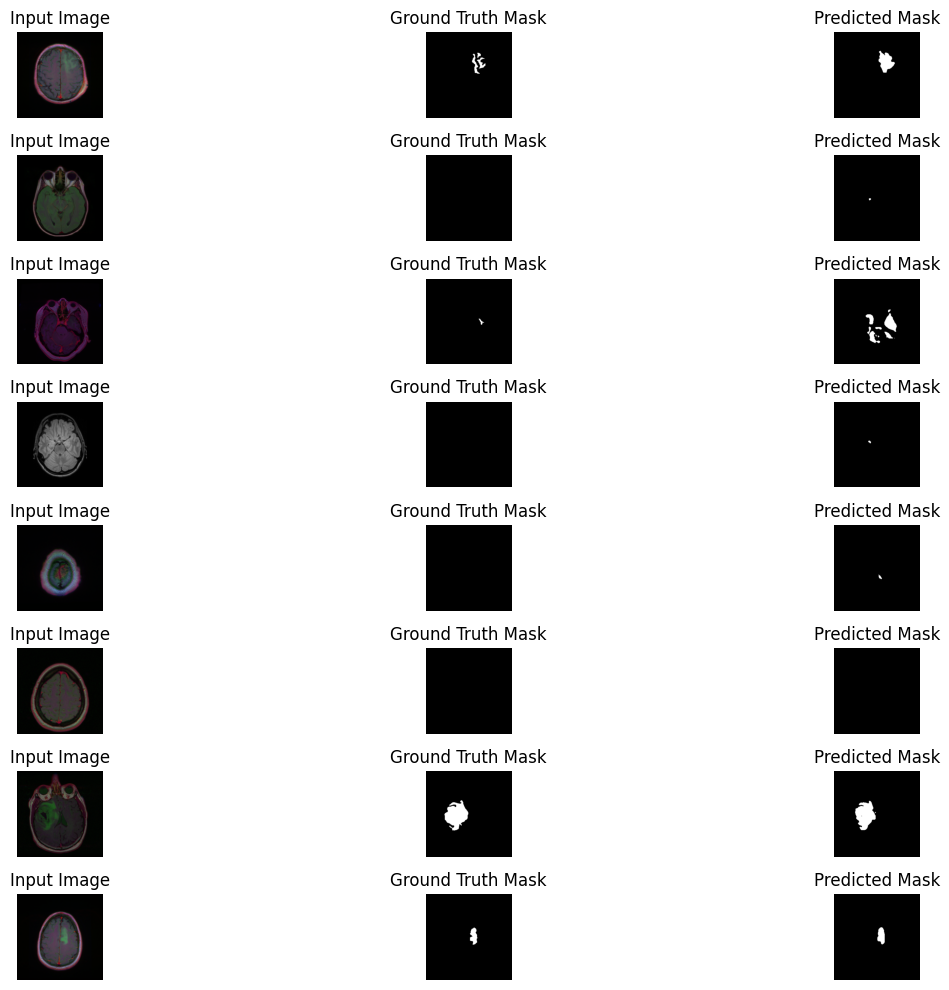

In [ ]:
# Model Evaluation
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs)

        num_samples = min(10, imgs.size(0))  # 10 samples

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            # Input Image
            plt.subplot(num_samples, 3, i*3+1)
            plt.imshow(imgs[i].permute(1, 2, 0).cpu())
            plt.title("Input Image")
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(num_samples, 3, i*3+2)
            plt.imshow(masks[i][0].cpu(), cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_samples, 3, i*3+3)
            plt.imshow((preds[i][0].cpu() > 0.5).numpy(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break


In [ ]:
# Save model weights after training
model_name = model.__class__.__name__.lower()
save_path = f"{model_name}_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to unet_weights.pth


Attention U net

In [ ]:
# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Attention U-Net
class AttentionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.dec4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        e4 = self.att4(g=d4, x=e4)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        e3 = self.att3(g=d3, x=e3)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        e2 = self.att2(g=d2, x=e2)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1 = self.att1(g=d1, x=e1)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


In [ ]:
# Model, Optimizer
model = AttentionUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
# Initialize Lists to collect losses and dice scores
train_losses = []
val_dice_scores = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation Dice Score
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            dice = dice_score(preds, masks)
            dices.append(dice.item())
    val_dice = np.mean(dices)
    val_dice_scores.append(val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Validation Dice: {val_dice:.4f}")

# After training print the lists
print("Training Losses:", train_losses)
print("Validation Dice Scores:", val_dice_scores)



100%|██████████| 393/393 [01:49<00:00,  3.58it/s]


Epoch [1/10] - Loss: 1.2517 - Validation Dice: 0.6343


100%|██████████| 393/393 [01:49<00:00,  3.58it/s]


Epoch [2/10] - Loss: 1.0640 - Validation Dice: 0.6594


100%|██████████| 393/393 [01:49<00:00,  3.59it/s]


Epoch [3/10] - Loss: 0.9639 - Validation Dice: 0.6121


100%|██████████| 393/393 [01:49<00:00,  3.59it/s]


Epoch [4/10] - Loss: 0.8932 - Validation Dice: 0.7824


100%|██████████| 393/393 [01:49<00:00,  3.59it/s]


Epoch [5/10] - Loss: 0.8479 - Validation Dice: 0.6225


100%|██████████| 393/393 [01:49<00:00,  3.58it/s]


Epoch [6/10] - Loss: 0.8097 - Validation Dice: 0.6613


100%|██████████| 393/393 [01:49<00:00,  3.59it/s]


Epoch [7/10] - Loss: 0.7848 - Validation Dice: 0.8134


100%|██████████| 393/393 [01:49<00:00,  3.59it/s]


Epoch [8/10] - Loss: 0.7714 - Validation Dice: 0.5658


100%|██████████| 393/393 [01:49<00:00,  3.58it/s]


Epoch [9/10] - Loss: 0.7622 - Validation Dice: 0.5955


100%|██████████| 393/393 [01:49<00:00,  3.58it/s]


Epoch [10/10] - Loss: 0.7494 - Validation Dice: 0.8536
Training Losses: [1.2516514217580548, 1.064034046259242, 0.9639204359843228, 0.8932374812871142, 0.8479346528308083, 0.8096505863824267, 0.784818195432197, 0.7714027393865222, 0.7622120135461404, 0.7494226949663866]
Validation Dice Scores: [np.float64(0.6343106269234359), np.float64(0.6594122103368393), np.float64(0.612063175048491), np.float64(0.7823645598960646), np.float64(0.6225406845109631), np.float64(0.6613340643469734), np.float64(0.8133773114344086), np.float64(0.5658196468244899), np.float64(0.5955475218067265), np.float64(0.8536355558669928)]


In [ ]:
attention_unet_losses = train_losses
attention_unet_dice = val_dice_scores


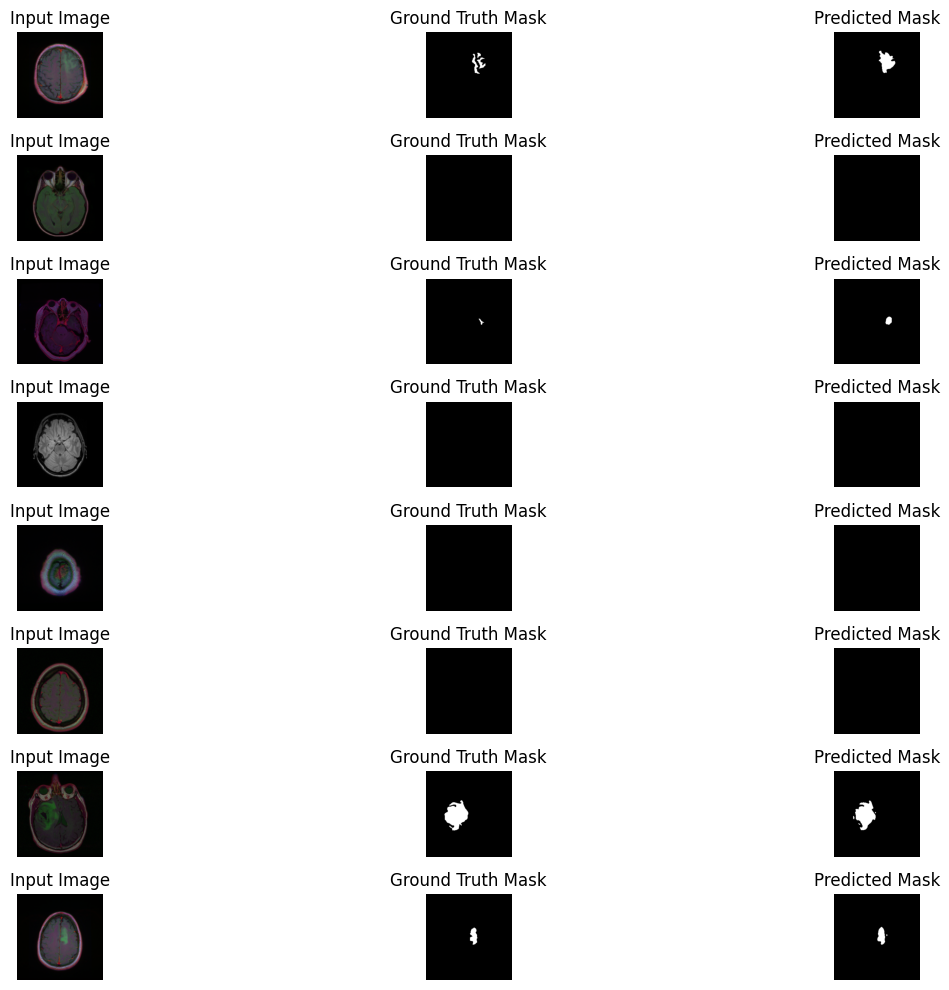

In [ ]:
# Model Evaluation
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs)

        num_samples = min(10, imgs.size(0))  # 10 samples

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            # Input Image
            plt.subplot(num_samples, 3, i*3+1)
            plt.imshow(imgs[i].permute(1, 2, 0).cpu())
            plt.title("Input Image")
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(num_samples, 3, i*3+2)
            plt.imshow(masks[i][0].cpu(), cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_samples, 3, i*3+3)
            plt.imshow((preds[i][0].cpu() > 0.5).numpy(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break


In [ ]:
# Save model weights after training
model_name = model.__class__.__name__.lower()
save_path = f"{model_name}_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to attentionunet_weights.pth


Residual UNet

In [ ]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += shortcut
        out = self.relu(out)
        return out

# Residual U-Net
class ResidualUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ResidualBlock(3, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.enc4 = ResidualBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ResidualBlock(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ResidualBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ResidualBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ResidualBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


In [ ]:
# Model, Optimizer
model = ResidualUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
# Initialize Lists to collect losses and dice scores
train_losses = []
val_dice_scores = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation Dice Score
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            dice = dice_score(preds, masks)
            dices.append(dice.item())
    val_dice = np.mean(dices)
    val_dice_scores.append(val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Validation Dice: {val_dice:.4f}")

# After training print the lists
print("Training Losses:", train_losses)
print("Validation Dice Scores:", val_dice_scores)



100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [1/10] - Loss: 0.9438 - Validation Dice: 0.6386


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [2/10] - Loss: 0.8170 - Validation Dice: 0.6315


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [3/10] - Loss: 0.7980 - Validation Dice: 0.7855


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [4/10] - Loss: 0.7821 - Validation Dice: 0.3890


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [5/10] - Loss: 0.7697 - Validation Dice: 0.7260


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [6/10] - Loss: 0.7667 - Validation Dice: 0.4429


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [7/10] - Loss: 0.7540 - Validation Dice: 0.8139


100%|██████████| 393/393 [01:48<00:00,  3.62it/s]


Epoch [8/10] - Loss: 0.7496 - Validation Dice: 0.6443


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [9/10] - Loss: 0.7405 - Validation Dice: 0.5467


100%|██████████| 393/393 [01:48<00:00,  3.63it/s]


Epoch [10/10] - Loss: 0.7371 - Validation Dice: 0.8279
Training Losses: [0.9438279289325685, 0.8169530319955209, 0.7980435808347989, 0.7820682794841495, 0.769703886511975, 0.7666688393090517, 0.7539689226914909, 0.7496385068535502, 0.7404611749200117, 0.7370760420351538]
Validation Dice Scores: [np.float64(0.6386078889622833), np.float64(0.6315453907456061), np.float64(0.7854889625250691), np.float64(0.3889545210533672), np.float64(0.7259678675068749), np.float64(0.4428705442132372), np.float64(0.8138593567742242), np.float64(0.644290027895359), np.float64(0.5466600731767789), np.float64(0.8278692400816715)]


In [ ]:
residual_unet_losses = train_losses
residual_unet_dice = val_dice_scores


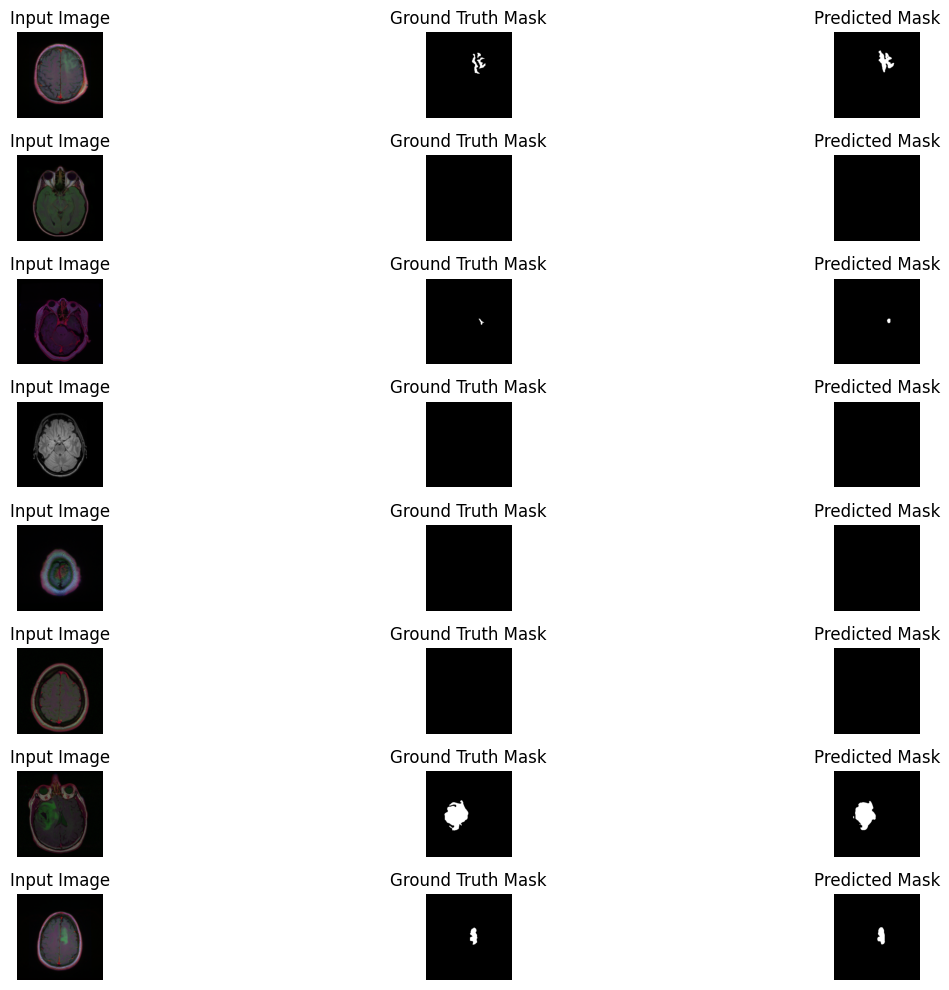

In [ ]:
# Model Evaluation
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs)

        num_samples = min(10, imgs.size(0))  # 10 samples

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            # Input Image
            plt.subplot(num_samples, 3, i*3+1)
            plt.imshow(imgs[i].permute(1, 2, 0).cpu())
            plt.title("Input Image")
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(num_samples, 3, i*3+2)
            plt.imshow(masks[i][0].cpu(), cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_samples, 3, i*3+3)
            plt.imshow((preds[i][0].cpu() > 0.5).numpy(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break


In [ ]:
# Save model weights after training
model_name = model.__class__.__name__.lower()
save_path = f"{model_name}_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to residualunet_weights.pth


U Net ++

In [ ]:
# U-Net++ (basic form)
class UNetPlusPlus(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        self.conv00 = ConvBlock(3, 64)
        self.conv10 = ConvBlock(64, 128)
        self.conv20 = ConvBlock(128, 256)
        self.conv30 = ConvBlock(256, 512)
        self.conv40 = ConvBlock(512, 1024)

        # Decoder
        self.up01 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv01 = ConvBlock(128, 64)

        self.up11 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv11 = ConvBlock(256, 128)

        self.up21 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv21 = ConvBlock(512, 256)

        self.up31 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv31 = ConvBlock(1024, 512)

        # Final conv
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))

        x31 = self.conv31(torch.cat([self.up31(x40), x30], dim=1))
        x21 = self.conv21(torch.cat([self.up21(x31), x20], dim=1))
        x11 = self.conv11(torch.cat([self.up11(x21), x10], dim=1))
        x01 = self.conv01(torch.cat([self.up01(x11), x00], dim=1))

        output = torch.sigmoid(self.final(x01))
        return output


In [ ]:
# Model, Optimizer
model = UNetPlusPlus().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
# Initialize Lists to collect losses and dice scores
train_losses = []
val_dice_scores = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation Dice Score
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            dice = dice_score(preds, masks)
            dices.append(dice.item())
    val_dice = np.mean(dices)
    val_dice_scores.append(val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Validation Dice: {val_dice:.4f}")

# After training print the lists
print("Training Losses:", train_losses)
print("Validation Dice Scores:", val_dice_scores)



100%|██████████| 393/393 [01:36<00:00,  4.08it/s]


Epoch [1/10] - Loss: 1.1748 - Validation Dice: 0.6398


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [2/10] - Loss: 1.0121 - Validation Dice: 0.3806


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [3/10] - Loss: 0.9260 - Validation Dice: 0.5669


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [4/10] - Loss: 0.8619 - Validation Dice: 0.7904


100%|██████████| 393/393 [01:35<00:00,  4.10it/s]


Epoch [5/10] - Loss: 0.8215 - Validation Dice: 0.3190


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [6/10] - Loss: 0.7995 - Validation Dice: 0.7349


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [7/10] - Loss: 0.7742 - Validation Dice: 0.7724


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [8/10] - Loss: 0.7609 - Validation Dice: 0.7693


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [9/10] - Loss: 0.7544 - Validation Dice: 0.6430


100%|██████████| 393/393 [01:36<00:00,  4.09it/s]


Epoch [10/10] - Loss: 0.7418 - Validation Dice: 0.7358
Training Losses: [1.1747514743538, 1.012127535792101, 0.9259976781051578, 0.8619399427154288, 0.8215322904762724, 0.7994562913746628, 0.7741915064155297, 0.7609274288018545, 0.7543719746077637, 0.7417560352472252]
Validation Dice Scores: [np.float64(0.6398100338198922), np.float64(0.38061178020305103), np.float64(0.5669480992688073), np.float64(0.7903607222768996), np.float64(0.3190045097067795), np.float64(0.7349159482753638), np.float64(0.7723539625153397), np.float64(0.7692907299056198), np.float64(0.6430002116795742), np.float64(0.7357763271741192)]


In [ ]:
unetpp_losses = train_losses
unetpp_dice = val_dice_scores

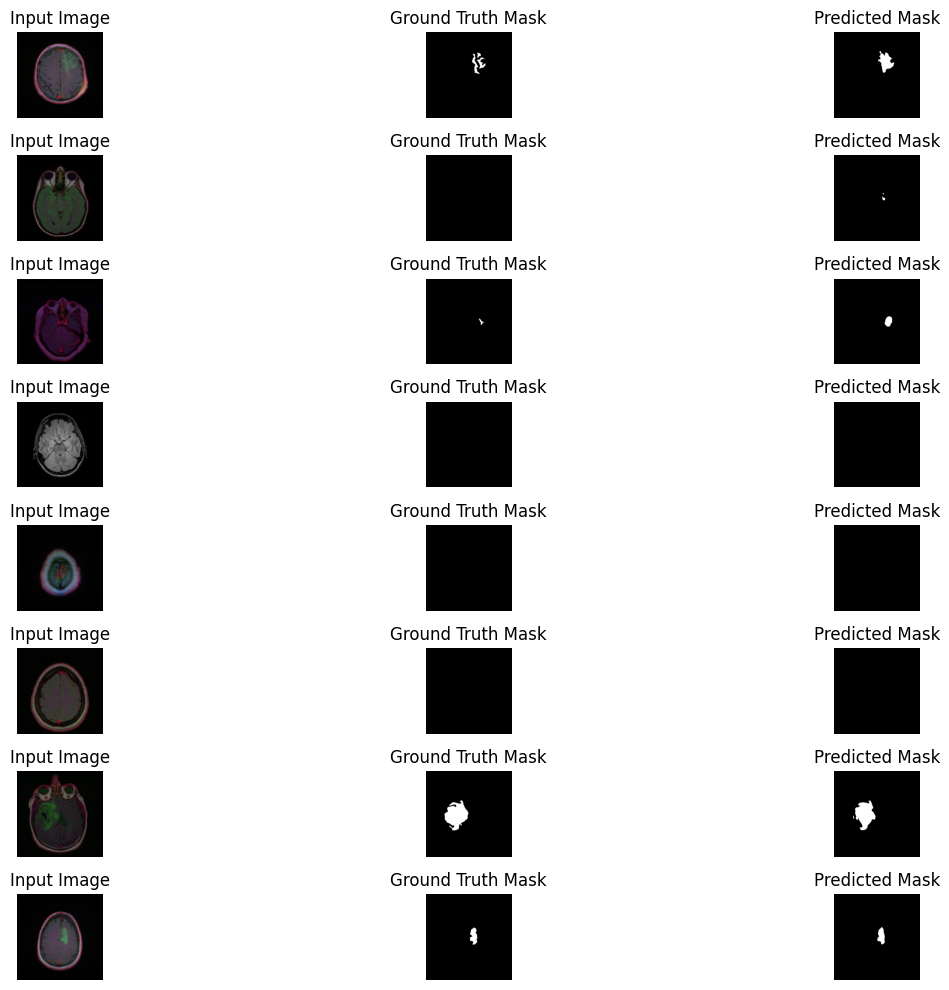

In [ ]:
# Model Evaluation
model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        preds = model(imgs)

        num_samples = min(10, imgs.size(0))  # 10 samples

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            # Input Image
            plt.subplot(num_samples, 3, i*3+1)
            plt.imshow(imgs[i].permute(1, 2, 0).cpu())
            plt.title("Input Image")
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(num_samples, 3, i*3+2)
            plt.imshow(masks[i][0].cpu(), cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_samples, 3, i*3+3)
            plt.imshow((preds[i][0].cpu() > 0.5).numpy(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break


In [ ]:
# Save model weights after training
model_name = model.__class__.__name__.lower()
save_path = f"{model_name}_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to unetplusplus_weights.pth


#Plots

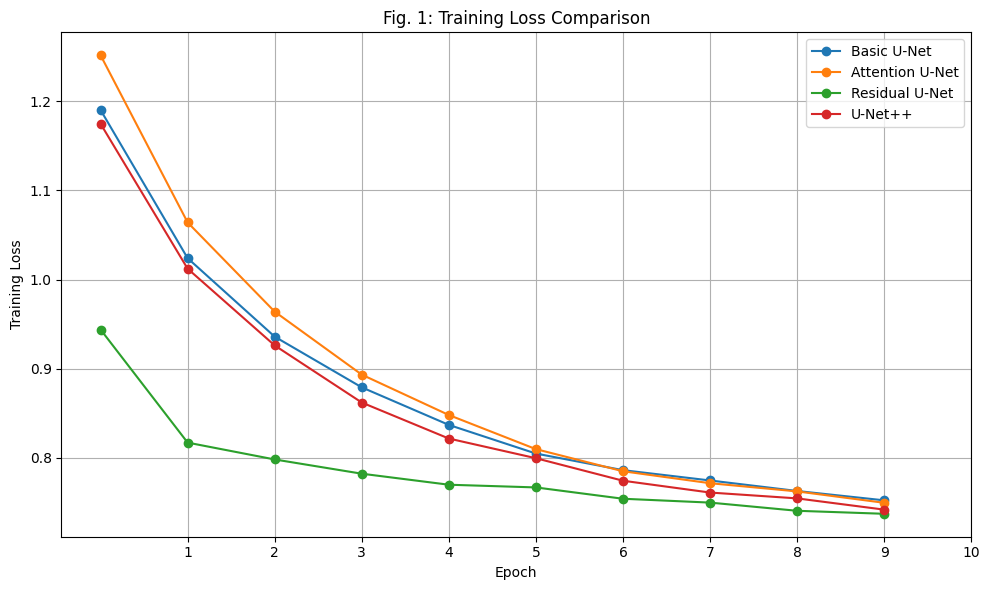

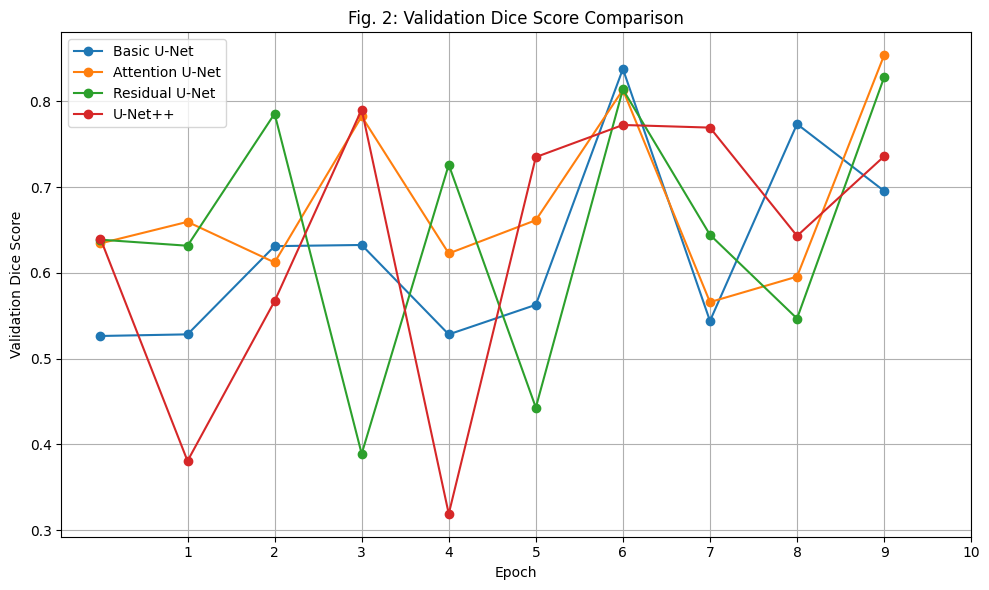

In [ ]:
import matplotlib.pyplot as plt

# ---- Training Loss Comparison ----
plt.figure(figsize=(10, 6))
plt.plot(basic_unet_losses, label='Basic U-Net', marker='o')
plt.plot(attention_unet_losses, label='Attention U-Net', marker='o')
plt.plot(residual_unet_losses, label='Residual U-Net', marker='o')
plt.plot(unetpp_losses, label='U-Net++', marker='o')
plt.title('Fig. 1: Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(basic_unet_losses)+1))  # Tick marks for each epoch
plt.tight_layout()
plt.savefig('training_loss_comparison.png')  # Save figure
plt.show()

# ---- Validation Dice Score Comparison ----
plt.figure(figsize=(10, 6))
plt.plot(basic_unet_dice, label='Basic U-Net', marker='o')
plt.plot(attention_unet_dice, label='Attention U-Net', marker='o')
plt.plot(residual_unet_dice, label='Residual U-Net', marker='o')
plt.plot(unetpp_dice, label='U-Net++', marker='o')
plt.title('Fig. 2: Validation Dice Score Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Score')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(basic_unet_dice)+1))
plt.tight_layout()
plt.savefig('validation_dice_score_comparison.png')  # Save figure
plt.show()
